<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Questions-to-Answer" data-toc-modified-id="Questions-to-Answer-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Questions to Answer</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Create-Fake-Training-Data" data-toc-modified-id="Create-Fake-Training-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create Fake Training Data</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Train-a-Linear-Model-Using-Batch-Gradient-Descent" data-toc-modified-id="Train-a-Linear-Model-Using-Batch-Gradient-Descent-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train a Linear Model Using Batch Gradient Descent</a></span></li><li><span><a href="#Train-a-Quadratic-Model-Using-Batch-Gradient-Descent" data-toc-modified-id="Train-a-Quadratic-Model-Using-Batch-Gradient-Descent-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train a Quadratic Model Using Batch Gradient Descent</a></span></li><li><span><a href="#Train-a-Cubic-Model-Using-Batch-Gradient-Descent" data-toc-modified-id="Train-a-Cubic-Model-Using-Batch-Gradient-Descent-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train a Cubic Model Using Batch Gradient Descent</a></span></li><li><span><a href="#Train-a-Polynomial-Model-Using-Batch-Gradient-Descent" data-toc-modified-id="Train-a-Polynomial-Model-Using-Batch-Gradient-Descent-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Train a Polynomial Model Using Batch Gradient Descent</a></span></li><li><span><a href="#Compute-Polynomial-Model-Using-Ordinary-Least-Squares" data-toc-modified-id="Compute-Polynomial-Model-Using-Ordinary-Least-Squares-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Compute Polynomial Model Using Ordinary Least Squares</a></span></li><li><span><a href="#Train-Neural-Network-Model-Using-Batch-Gradient-Descent" data-toc-modified-id="Train-Neural-Network-Model-Using-Batch-Gradient-Descent-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Train Neural Network Model Using Batch Gradient Descent</a></span></li></ul></div>

# Overfitting a Curve

In this assignment, you will play around with the various models and corresponding parameters. 

## Questions to Answer

Things to try:

- **Before you run any code**, make some predictions. What do you expect to see for the different models?
    + linear
    + quadratic
    + cubic
    + $n$ degree polynomial
    + neural network
- Now run the notebook. What surprised you?
- Now report on your results with the following:
    + Changing the number of degrees in the polynomial model.
    + Using a non-zero weight decay for the neural network model.
    + Changing the number of layers in the neural network model.
    + Changing the number of training samples.
- Finally, open the [second notebook for this assignment](https://github.com/anthonyjclark/cs152sp22/blob/main/Assignments/A08-Overfitting/OverfittingFashionMNIST.ipynb) and see if you can get the neural network to overfit the data (get the bad thing to happen).

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

from fastprogress.fastprogress import progress_bar

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

In [2]:
# Number of training examples
train_N = 20

# Range of training data input
MIN_X, MAX_X = -1, 1

## Create Fake Training Data

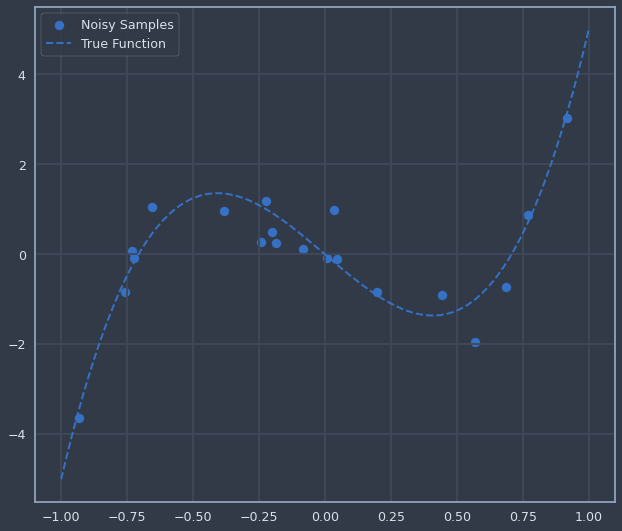

In [3]:
def fake_y(x, add_noise=False):
    y = 10 * x ** 3 - 5 * x
    return y + torch.randn_like(y) * 0.5 if add_noise else y


true_N = 100
true_X = torch.linspace(MIN_X, MAX_X, true_N)
true_y = fake_y(true_X)

train_X = torch.rand(train_N) * (MAX_X - MIN_X) + MIN_X
train_y = fake_y(train_X, add_noise=True)

plt.scatter(train_X, train_y, label="Noisy Samples")
plt.plot(true_X, true_y, "--", label="True Function")
_ = plt.legend()

## Utilities

In [4]:
def plot_curves(ax, model=None, MSE=None, poly_deg=0):

    # Plot the noisy scatter points and the "true" function
    ax.scatter(train_X, train_y, label="Noisy Samples")
    ax.plot(true_X, true_y, "--", label="True Function")

    # Plot the model's learned regression function
    if model:
        x = true_X.unsqueeze(-1)
        x = x.pow(torch.arange(poly_deg + 1)) if poly_deg else x

        with torch.no_grad():
            pred_y = model(x)

        ax.plot(true_X, pred_y, label="Learned Curve")

    ax.set_xlim([MIN_X, MAX_X])
    ax.set_ylim([-5, 5])
    ax.legend()
    if MSE:
        ax.set_title(f"MSE = ${MSE:.5f}$")


def plot(model=None, losses=None, poly_deg=0):

    if losses:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    else:
        _, ax1 = plt.subplots(1, 1, figsize=(8, 8))

    loss = losses[-1] if losses else None
    plot_curves(ax1, model, MSE=loss, poly_deg=poly_deg)

    if losses:
        ax2.plot(losses)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Loss")


def train_model(X, y, lr, ne, wd, model, params):
    # Hyperparameters
    learning_rate = lr
    num_epochs = ne

    # Torch utils
    criterion = nn.MSELoss()
    optimizer = optim.SGD(params, lr=learning_rate, weight_decay=wd)

    losses = []

    # Training loop
    for epoch in progress_bar(range(num_epochs)):
        # Model
        yhat = model(X)

        # Compute loss
        loss = criterion(yhat.squeeze(), y)
        losses.append(loss.item())

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

## Train a Linear Model Using Batch Gradient Descent

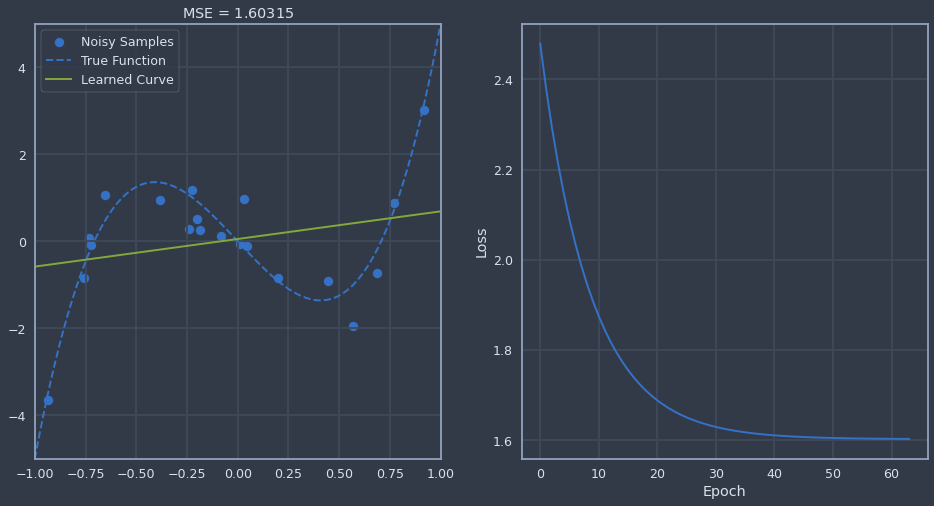

In [5]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 64
weight_decay = 0

# Model parameters
m = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Place parameters into a sequence for torch.optim
params = (b, m)

# Create simple linear model
def model(X):
    return m * X + b


losses = train_model(
    train_X, train_y, learning_rate, num_epochs, weight_decay, model, params
)
plot(model, losses)

## Train a Quadratic Model Using Batch Gradient Descent

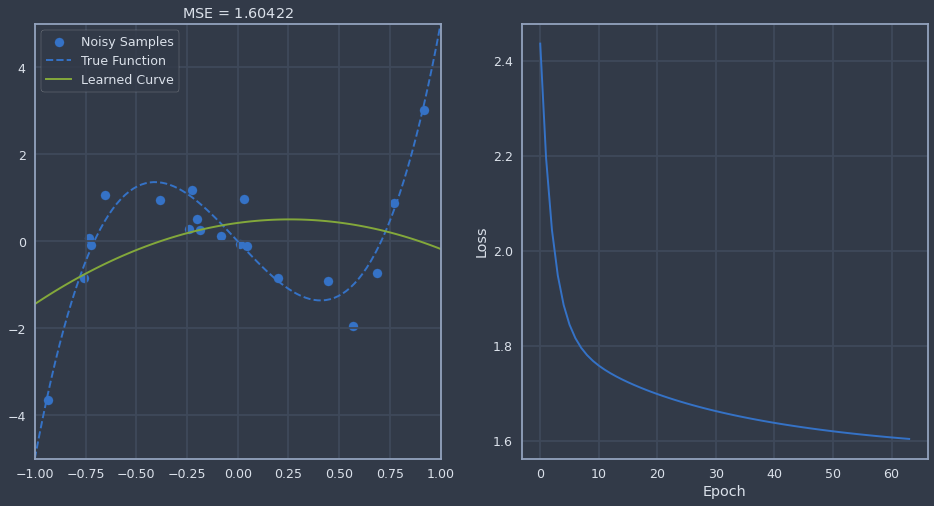

In [6]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 64
weight_decay = 0

# Model parameters
w2 = torch.randn(1, requires_grad=True)
w1 = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Place parameters into a sequence for torch.optim
params = (b, w1, w2)

# Create simple quadratic model
def model(X):
    return b + w1 * X + w2 * X ** 2


losses = train_model(
    train_X, train_y, learning_rate, num_epochs, weight_decay, model, params
)
plot(model, losses)

## Train a Cubic Model Using Batch Gradient Descent

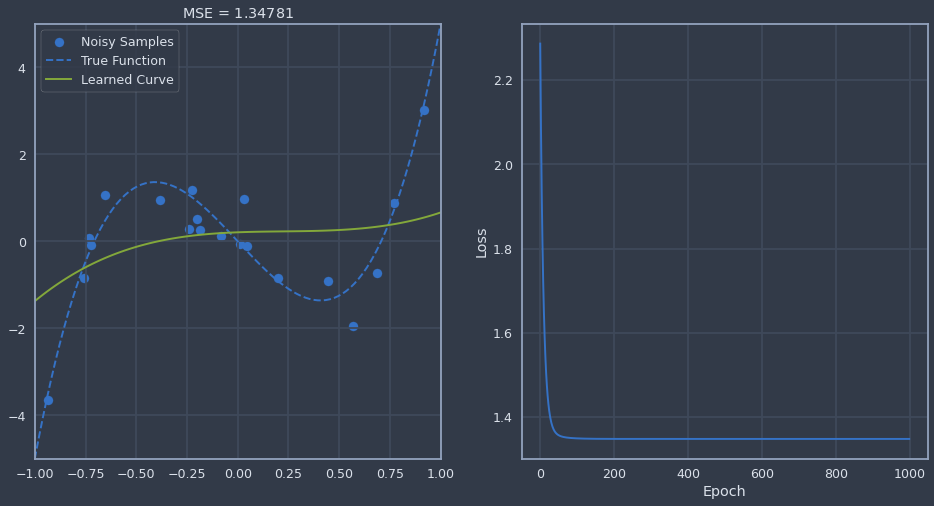

In [7]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 1000
weight_decay = 0

# Model parameters
w3 = torch.randn(1, requires_grad=True)
w2 = torch.randn(1, requires_grad=True)
w1 = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Place parameters into a sequence for torch.optim
params = (b, w1, w2)

# Create simple cubic model
def model(X):
    return b + w1 * X + w2 * X ** 2 + w3 * X ** 3


losses = train_model(
    train_X, train_y, learning_rate, num_epochs, weight_decay, model, params
)
plot(model, losses)

## Train a Polynomial Model Using Batch Gradient Descent

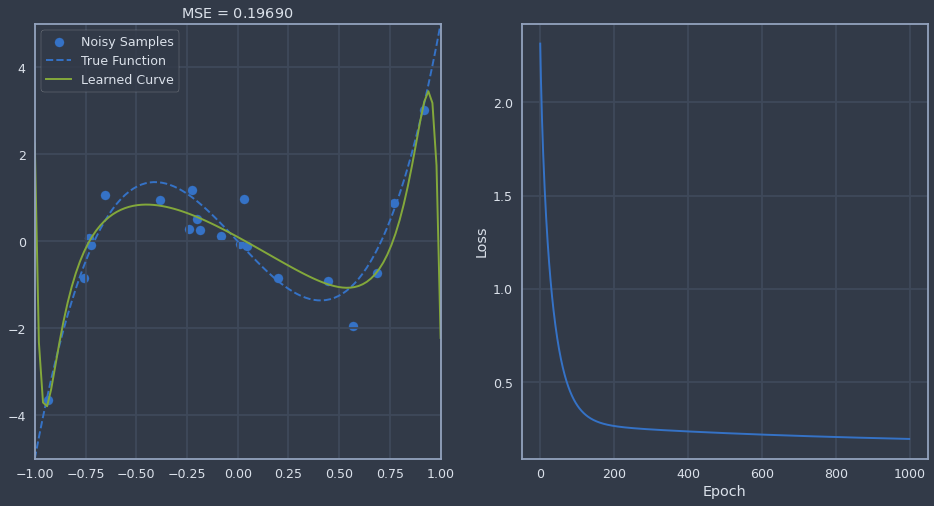

In [8]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 1000
weight_decay = 0

# Model parameters
degrees = 50  # 3, 4, 16, 32, 64, 128
powers = torch.arange(degrees + 1)
x_poly = train_X.unsqueeze(-1).pow(powers)
params = torch.randn(degrees + 1, requires_grad=True)

# Create simple cubic model
def model(X):
    return X @ params


losses = train_model(x_poly, train_y, learning_rate, num_epochs, weight_decay, model, [params])
plot(model, losses, poly_deg=degrees)

## Compute Polynomial Model Using Ordinary Least Squares

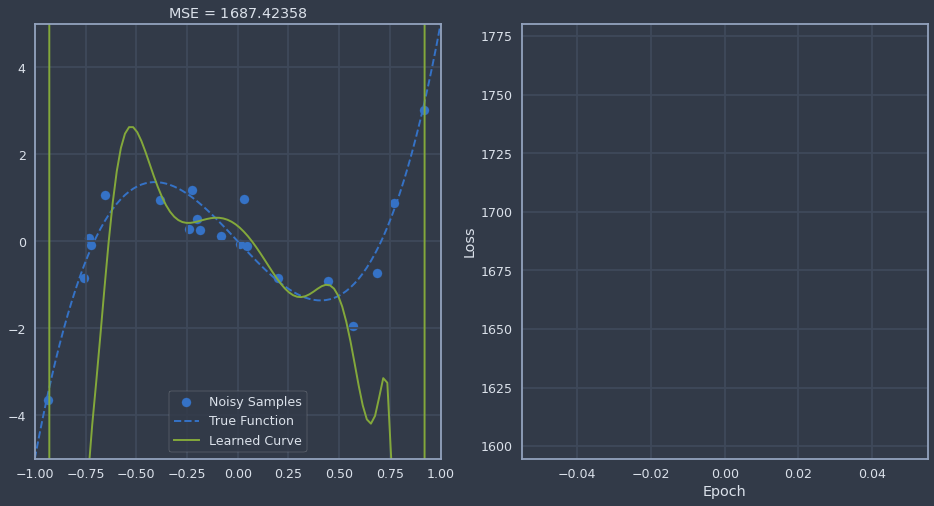

In [9]:
# Compute "optimal" parameters
params = ((x_poly.T @ x_poly).inverse() @ x_poly.T) @ train_y


def model(X):
    return X @ params


# Compute loss
mse = nn.functional.mse_loss(x_poly @ params, train_y)

plot(model, [mse], poly_deg=degrees)

In [ ]:
params.abs().mean()

## Train Neural Network Model Using Batch Gradient Descent

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  200
|    |    └─ReLU: 3-2                    --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-3                  10,100
|    |    └─ReLU: 3-4                    --
|    └─Sequential: 2-3                   --
|    |    └─Linear: 3-5                  10,100
|    |    └─ReLU: 3-6                    --
|    └─Linear: 2-4                       101
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0


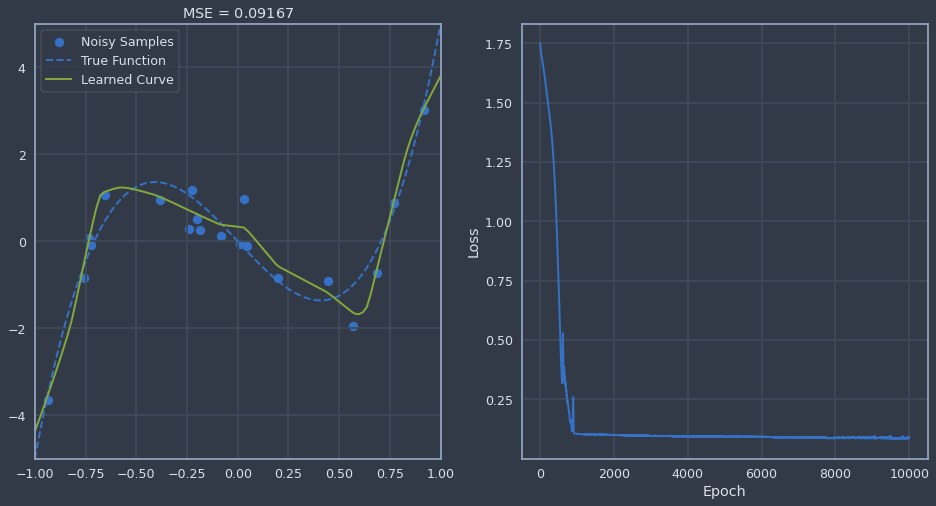

In [11]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 10000
weight_decay = 0

layer_sizes = (1, 100, 100, 100, 1)

model = NeuralNetwork(layer_sizes)
summary(model)

X = train_X.unsqueeze(-1)

losses = train_model(X, train_y, learning_rate, num_epochs, weight_decay, model, model.parameters())
plot(model, losses)

In [12]:
for param in model.parameters():
    print(param.abs().mean().item())

0.5724272727966309
0.4693448543548584
0.05346180498600006
0.05883307754993439
0.0531676821410656
0.0557423010468483
0.1793680042028427
0.10072831064462662
